In [1]:
import pickle as pkl
from glob import glob
#import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
list_files = glob("../models/MI_measures/*copulaMI.pkl")

In [814]:
def marginal_file_name(string):
    arr = str.split(string,sep='_')
    return f"{arr[0]}_{arr[1]}_{arr[2]}_marginalMI.pkl"
def linear_file_name(string):
    arr = str.split(string,sep='_')
    return f"{arr[0]}_{arr[1]}_{arr[2]}_linearMI.pkl"
def load_data(string):
    with open(string,"rb") as f:
        copula = pkl.load(f)
    with open(marginal_file_name(string),"rb") as f:
        marginal = pkl.load(f)
    with open(linear_file_name(string),"rb") as f:
        linear = pkl.load(f)
    return (linear,marginal,copula)
def name(i):
    if i>1:
        return i
    elif i==1:
        return 'average'
    elif i==0:
        return 'bg'
    elif i==-1:
        return 'V'
    elif i==-2:
        return 'licks'
    elif i==-3:
        return 'reward'
    elif i==-4:
        return 'ER'
    elif i==-5:
        return 'LR'
def make_node_list(N):
    l = [name(i-5) for i in range(N)] #5 behavioural variables
    return l

In [815]:
list_files

['../models/MI_measures/ST260_Day1_copulaMI.pkl',
 '../models/MI_measures/ST264_Day4_copulaMI.pkl',
 '../models/MI_measures/ST262_Day2_copulaMI.pkl',
 '../models/MI_measures/ST260_Day3_copulaMI.pkl',
 '../models/MI_measures/ST262_Day4_copulaMI.pkl',
 '../models/MI_measures/ST264_Day3_copulaMI.pkl',
 '../models/MI_measures/ST260_Day4_copulaMI.pkl',
 '../models/MI_measures/ST263_Day1_copulaMI.pkl',
 '../models/MI_measures/ST263_Day4_copulaMI.pkl',
 '../models/MI_measures/ST264_Day1_copulaMI.pkl']

In [2148]:
dayname = 'ST263_Day2'
filename = f"../models/{dayname}/summary.pkl"
with open(filename,'rb') as f:
    summary = pkl.load(f)
filename = f"../models/MI_measures/{dayname}_copulaMI.pkl"
linear0, marginal0, copula0 = load_data(filename)
marginal0[2,4] /= 2
# copula0[...,2] = -copula0[...,2] #messed up with entropy sign
# copula0[...,3] = -copula0[...,3] #messed up with entropy sign
t = str.split(filename,'_')[1:3]
title = str.split(t[0],'/')[-1]+' '+t[1]

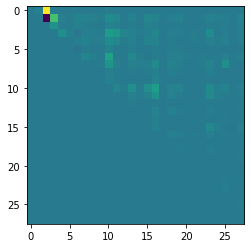

In [2149]:
plt.imshow(-linear0)

In [2150]:
k,b = np.polyfit(-linear0[7:,7:].flatten(),copula0[7:,7:,0].flatten(),1)

2 21


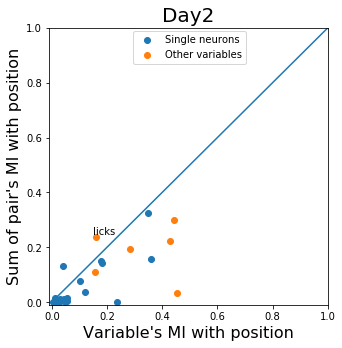

In [2151]:
# from matplotlib.transforms import Affine2D
# import mpl_toolkits.axisartist.floating_axes as floating_axes

marginal = marginal0
sumH = np.empty_like(marginal[0])
Nv = copula0.shape[0]
for i in range(Nv):
    s = 0
    for j in range(Nv):
        s+=copula0[min(i,j),max(i,j),0]
    sumH[i] = s/(Nv/30)
fig = plt.figure(figsize=(5,5.1))
mask = marginal[0]>0
plt.scatter(marginal[0][7:][mask[7:]],sumH[7:][mask[7:]], label='Single neurons')
plt.scatter(marginal[0][:7][mask[:7]],sumH[:7][mask[:7]], label='Other variables')
x = np.linspace(0,1,100) #np.max(marginal[0])
plt.plot(x,x)
plt.xlabel('Variable\'s MI with position', fontsize=16)
plt.ylabel('Sum of pair\'s MI with position', fontsize=16)
#plt.ylim(-0.01,np.max(sumH)+0.01)
plt.xlim(-0.01,1.001)
plt.ylim(-0.01,1.001)
plt.title(title[6:], fontsize=20) #title
plt.legend(loc=(0.3,0.87))

nodelist = np.array(make_node_list(Nv))
#labels = nodelist[sumH>marginal[0]]
labels = []
for x,y,t in zip (marginal[0][:7][mask[:7]],sumH[:7][mask[:7]],nodelist[:7][mask[:7]]):
    if (y>x) & ((y>0.02) | (x>0.02)):
        plt.text(x-0.01,y+0.01,t)
        labels.append(t)
np.array(labels)

print(np.sum(sumH[7:][mask[7:]]>=marginal[0][7:][mask[7:]]),len(marginal[0][7:][mask[7:]]))

# plot_extents = -0.25, 0.25, 0.5, 0.55
# transform = Affine2D().rotate_deg(-45)
# helper = floating_axes.GridHelperCurveLinear(transform, plot_extents)
# ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)

# fig.add_subplot(ax)

fig.savefig(f"SP_{title}.pdf")

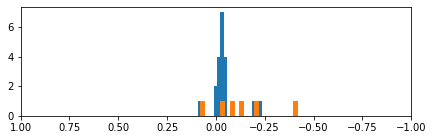

In [2152]:
fig = plt.figure(figsize=(7,2))
plt.hist(sumH[7:][mask[7:]]-marginal[0][7:][mask[7:]],bins=20)
plt.hist(sumH[:7][mask[:7]]-marginal[0][:7][mask[:7]],bins=20)
plt.xlim(1,-1)
fig.savefig(f"hist_{title}.pdf")

In [2153]:
model_type = np.zeros_like(summary).astype('int')
for i in range(summary.shape[0]):
    for j in range(summary.shape[1]):
        if summary[i,j]!=None:
            if summary[i,j][1]=='Independence':
                model_type[i,j] = 0
            elif (summary[i,j][1]=='Gaussian') | (summary[i,j][1]=='IndependenceGaussian') | \
                (summary[i,j][1]=='Frank') | (summary[i,j][1]=='IndependenceFrank'):
                model_type[i,j] = 1
            else:
                model_type[i,j] = 2

In [2154]:
# xy[0,:] = np.array([-1/2,-(3/4)**(1/2)])*small_r #LR
# xy[1,:] = np.array([+1/2,-(3/4)**(1/2)])*small_r #ER
# xy[2,:] = np.array([+1,0])*small_r #rew
# xy[3,:] = np.array([-1,0])*small_r #lick
# xy[4,:] = [0,0] #vel
# xy[5,:] = np.array([+1/2,+(3/4)**(1/2)])*small_r #bg
# xy[6,:] = np.array([-1/2,+(3/4)**(1/2)])*small_r #neuropil

In [2166]:
def get_important_variables(Nv,marginal0,copula0,thr=0.001):
    variables = np.zeros(Nv)
    for i in range(7,len(variables)):
        if marginal0[0,i]>thr:
            variables[i] = 1
        else:
            s = 0
            for j in range(Nv):
                s+=np.clip(copula0[min(i,j),max(i,j),0],1e-2,float("inf"))-1e-2
            if s>thr:
                variables[i] = 1
    variables[:7] = 0
    variables[0] = 0 #no LR
    variables[5] = 0 #no background
    return variables

variables = get_important_variables(copula0.shape[0],marginal0,copula0)

In [2167]:
#var1 = variables
#variables = (var1 >= 1.0) * 1
#variables = ((var1 + var2 + var3)>=1.0)*1
#np.sum(variables)/len(variables)

In [2168]:
import cmocean
cmap = cmocean.tools.crop_by_percent(cmocean.tools.crop_by_percent(cmocean.cm.phase, 10, which='min', N=None), 40, which='max', N=None)
#cmap = matplotlib.cm.get_cmap('viridis')

In [2169]:
def _is_outlier(thr,l,c):
    first = np.sum(thr[0]<l)
    if first==0:
        d_min = thr[1,0]
    elif first == len(thr[0]):
        d_min = thr[1,-1]
    else:
        d_min = (thr[1,first-1]+thr[1,first])/2
    if c>=k*l+b+d_min:
        return 1
    else:
        return 0

/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


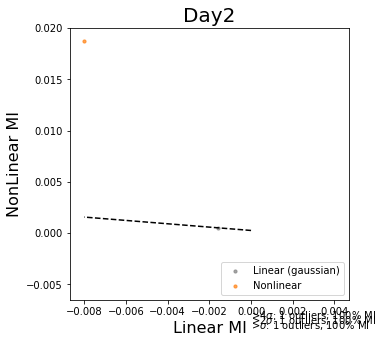

In [2180]:
import matplotlib

Nv0 = copula0.shape[0] #total number of variables 
assert Nv0==copula0.shape[1]
assert Nv0==marginal0.shape[1]

sc = Nv0/5 #scale
nodelist = make_node_list(Nv0)
nodelist = np.array(nodelist)[variables==1]

marginal = marginal0.T[variables==1].T
copula = copula0[variables==1][:,variables==1]
linear = -linear0[variables==1][:,variables==1] #SIGN!
models = model_type[variables==1][:,variables==1]
Nv = copula.shape[0]

mark = np.zeros_like(copula0[...,0])
mN = 5
mark[mN+5,:] = 1
mark[:,mN+5] = 1
mark = (mark[variables==1][:,variables==1])[5:,5:].flatten()

fig = plt.figure(figsize=(5,5))
l,c,t=linear[5:,5:].flatten(),copula[5:,5:,0].flatten(),models[5:,5:].flatten()
#c[t==1] = l[t==1]
#mask = (c>1e-2) & ((c>1e-2) | (l>1e-2))
mask = (c>0) & (t==1)
plt.scatter(l[mask],c[mask],alpha=0.7,s=10,color='grey',label='Linear (gaussian)')
(k,b) = np.polyfit(l[mask],c[mask],1)
mask = (c>0) & (t==2)
plt.scatter(l[mask],c[mask],alpha=0.7,s=10, color='C1', label='Nonlinear')
x = np.linspace(0,np.max(l[mask]),100)
plt.plot(x,x*k+b,c='black',linestyle='dashed')

mask = (c>0) & (t==1)
order = np.argsort(l[mask])
hb = 1 #half-batch 10
n = len(l[mask])-2*hb
thr = np.zeros((2,n+2))
X = l[mask][order]
Y = c[mask][order]
for i in range(hb,n+hb):
    thr[0,i-hb+1] = X[i-hb:i+hb].mean()
    thr[1,i-hb+1] = (Y[i-hb:i+hb]-k*X[i-hb:i+hb]-b).std()
thr_orig = thr
thr[1][2:-2] = (4*thr[1][2:-2] + 2*np.roll(thr[1][2:-2],1) + 2 *np.roll(thr[1][2:-2],-1) \
                + np.roll(thr[1][2:-2],1)+ np.roll(thr[1][2:-2],-1))/10
thr[0,0]=-0.002
thr[1,0]=thr[1,1]
thr[0,-1] = 0.06
thr[1,-1] = thr[1,-2]
plt.fill_between(thr[0],k*thr[0]+b+thr[1],np.clip(k*thr[0]+b-thr[1],-0.002,1),color='grey',alpha=0.3)
plt.fill_between(thr[0],k*thr[0]+b+2*thr[1],np.clip(k*thr[0]+b-2*thr[1],-0.002,1),color='grey',alpha=0.3)
plt.fill_between(thr[0],k*thr[0]+b+4*thr[1],np.clip(k*thr[0]+b-4*thr[1],-0.002,1),color='grey',alpha=0.3)
thr = thr_orig

# find outliers
mask = (t>0) & (c>1e-3)
c =c[mask]
out = np.empty_like(c)
for i in range(len(c)):
    out[i] = _is_outlier(thr,l[mask][i],c[i])
N_out = np.sum(out).astype('int')
MIp = np.sum(c[out==1])/np.sum(c)*100
plt.text(0,0.057*k,f">$\sigma$: {N_out} outliers, {MIp:.0f}% MI")
out = np.empty_like(c)
for i in range(len(c)):
    out[i] = _is_outlier(2*thr,l[mask][i],c[i])
N_out = np.sum(out).astype('int')
MIp = np.sum(c[out==1])/np.sum(c)*100
plt.text(0,0.054*k,f">2$\sigma$: {N_out} outliers, {MIp:.0f}% MI")
out = np.empty_like(c)
for i in range(len(c)):
    out[i] = _is_outlier(4*thr,l[mask][i],c[i])
N_out = np.sum(out).astype('int')
MIp = np.sum(c[out==1])/np.sum(c)*100
plt.text(0,0.051*k,f">4$\sigma$: {N_out} outliers, {MIp:.0f}% MI")

plt.xlabel('Linear MI', fontsize = 16)
plt.ylabel('NonLinear MI', fontsize = 16)
plt.title(title[6:], fontsize=20) #title
plt.legend(loc=4)

# plt.scatter(l[mask],c[mask]/l[mask]-1,alpha=0.3,s=3)
# #plt.scatter(l[mask & (mark==1)],c[mask& (mark==1)]-l[mask & (mark==1)],alpha=0.5)
# x = np.linspace(0,np.max(l[mask]),100)
# plt.xlabel('Linear MI')
# plt.ylabel('NonLinear MI/Linear MI - 1')
# perc = lambda x: np.sum(c[mask]>x*(l[mask]+bias))/len(c[mask])*100 
plt.xlim(-0.002,0.06)
plt.ylim(-0.002,0.06*k)
fig.savefig(f"LNL_{title}.pdf")
# plt.axhline(0,color='black')
# plt.axvline(0.01,color='black',linestyle='dashed',linewidth=0.5)
# print(perc(1),perc(1.1),perc(1.2))

In [2181]:
out = np.empty_like(c)
for i in range(len(c)):
    out[i] = _is_outlier(thr,l[i],c[i])
(np.sum(c[out==1])/np.sum(c), np.sum(c[(out==1) & (c>1e-2)])/np.sum(c[c>1e-2]))

(1.0, 1.0)

0.002097374941856755 0.0
2


/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1720: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


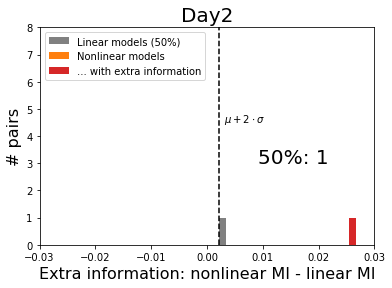

In [2184]:
import scipy.stats as stats

fig = plt.figure()
l,c,t=linear[5:,5:].flatten(),copula[5:,5:,0].flatten(),models[5:,5:].flatten()
mask = (c>0.01) & (t==1)
lin = c[mask]-l[mask]
mask = (c>0.01) & (t==2)
nonlin = c[mask]-l[mask]
print(lin.mean(),lin.std())
thr0 = lin.mean() + 2*lin.std()
plt.hist((lin,nonlin[nonlin<=thr0],nonlin[nonlin>thr0]), stacked=True, bins=20,
         label = (f"Linear models ({100*len(lin)/(len(lin)+len(nonlin)):.0f}%)",
                  'Nonlinear models',
                  f"... with extra information"),
         color = ('grey','C1','C3')
        )
#plt.xlim(np.min(lin)*1.1,np.max(nonlin)*1.3)
plt.xlim(-0.03,0.03)
plt.ylim(0,8) #112/2
x = np.linspace(-0.03,0.07, 100) #np.max(nonlin)
plt.plot(x, stats.norm.pdf(x, lin.mean(), lin.std())/70,color='black')
plt.axvline(thr0,color='black',linestyle='dashed')
plt.text(lin.mean()+2*lin.std()+0.007,3,f"{100*np.sum(nonlin>thr0)/(len(nonlin)+len(lin)):.0f}%: {np.sum(nonlin>thr0)}",fontsize=20)
plt.text(lin.mean()+2*lin.std()+0.001,4.5,"$\mu+2\cdot\sigma$",fontsize=10)
plt.xlabel('Extra information: nonlinear MI - linear MI',fontsize=16)
plt.ylabel('# pairs',fontsize=16)
plt.legend(loc=2)
plt.title(title[6:], fontsize=20) #title
fig.savefig(f"LNLhist_{title}.pdf")
print(len(lin) + len(nonlin))

In [2114]:
#find those above threshold
sh = copula0[5:].shape[0]
gr = np.mgrid[0:sh,0:sh]
mask = (copula0[5:,5:,0]-linear0[5:,5:]>-0.0025) & (linear0[5:,5:]>0.01)
np.array([gr[0][mask],gr[1][mask]]).T
#copula[5:,5:,0]-linear[5:,5:]>thr0

array([[ 0, 11]])

In [2054]:
copula0

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.03176103, 0.00190719, 0.08559769, 0.00724553],
        [0.02348499, 0.00104394, 0.26082206, 0.00792549],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.04109189, 0.00232873, 0.20343423, 0.00816729],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.00811588, 0.002144

7 26 -0.012743230382668282 34.5
9 21 -0.022337321653266073 47.3
21 33 -0.015800531335801348 29.4


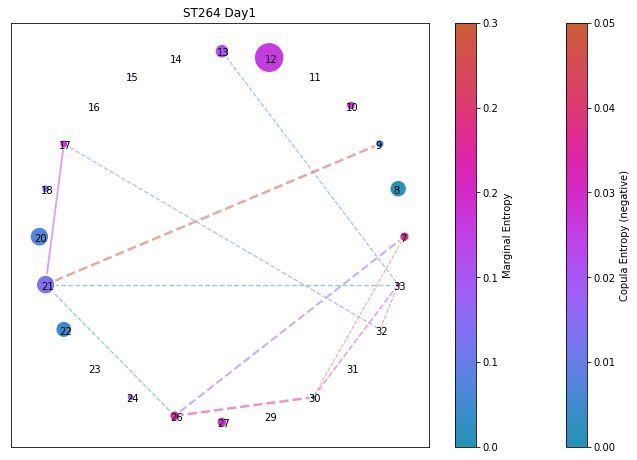

In [2006]:
sizes = np.clip(marginal[0][5:],0.01,2.)*10
dsizes = marginal[1][5:]*sc/5
#sizes = marginal[1]*500
#dsizes = np.zeros_like(marginal[1])
angles = 2*np.pi*(np.arange(Nv)-5)/(Nv-5)
big_R = sc*5
xy = np.stack([np.cos(angles),np.sin(angles)]).T*big_R
small_r = big_R/2
for i in range(5):
    angle = 2*np.pi*i/5
    xy[i,:] = np.array([np.cos(angle),np.sin(angle)])*small_r #LR

dHm = np.max(marginal[2]-np.min(marginal[2]))#-np.min(marginal[2])
Hs = copula[...,2].flatten()[copula[...,0].flatten()>1e-2]
#Hs = copula[...,3].flatten()[copula[...,1].flatten()>0.5*1e-2]
H_max = np.max(Hs)
#H_max=0.07
dH = H_max - 0.0
bias = 0
colors = cmap(1-(marginal[2]-np.min(marginal[2]))/dHm)

fig, ax = plt.subplots(figsize=(1.5*sc,sc))

def draw_lines(Is,zorder):
    linewidth, segs, line_colors, line_styles = [], [], [], []
    for i in Is:
        for j in range(i+1,Nv):
            if copula[i,j,0]>1e-2:
            #if copula[i,j,1]>5*1e-3:
                segs.append([xy[i],xy[j]])
                linewidth.append((copula[i,j,0]*100))
                line_colors.append(cmap((H_max-copula[i,j,2])/dH))
                if _is_outlier(thr,linear[i,j],copula[i,j,0]):
                    line_styles.append('dashed')
                    if _is_outlier(4*thr,linear[i,j],copula[i,j,0]):
                        print(nodelist[i],nodelist[j],linear[i,j],
                          f"{(copula[i,j,0]-linear[i,j])*1e3:.1f}")
                else:
                    line_styles.append('solid')
#                     if linear[i,j]>0.05:
#                         print(nodelist[i],nodelist[j],linear[i,j],
#                           f"{(copula[i,j,0]-linear[i,j])*1e3:.1f}")
            elif copula[i,j,0]==0:
                if (linear[i,j]>0.03):
                    pass
#                     print(nodelist[i],nodelist[j],linear[i,j],
#                           f"{(linear[i,j])*100:.1f}")
                
    line_segments = matplotlib.collections.LineCollection(segs, linewidths=linewidth,
                                   colors=line_colors, linestyles=line_styles,zorder=zorder, alpha=0.5)
    return line_segments
# lines = draw_lines(range(0,5),2)
# ax.add_collection(lines)
lines = draw_lines(range(5,Nv-1),0)
ax.add_collection(lines)

# circle = plt.Circle([0,0],small_r*1.2,zorder=1,linewidth=1,edgecolor='black',facecolor='white',alpha=0.8)
# ax.add_patch(circle)

s = 1.0
out_space = 3
for text, c in zip(nodelist[5:],xy[5:]):
    if c[0]**2+c[1]**2 <= small_r**2:
        ax.text(c[0]-s+np.sign(c[0])*out_space,
            c[1]-s+np.sign(c[1])*out_space,text,bbox=dict(facecolor='white', alpha=0.8, linewidth=0),zorder=10)
    else:
        ax.text(c[0]-s,c[1]-s,text,zorder=10)

# Note that the patches won't be added to the axes, instead a collection will
patches_min = [plt.Circle(center, size) for center, size in zip(xy[5:], sizes-dsizes)]
patches_max = [plt.Circle(center, size) for center, size in zip(xy[5:], sizes+dsizes)]

coll = matplotlib.collections.PatchCollection(patches_min, facecolors=colors, alpha=0.2,zorder=10)
ax.add_collection(coll)
coll = matplotlib.collections.PatchCollection(patches_max, facecolors=colors, edgecolors='white', linewidth=2,zorder=10)
ax.add_collection(coll)

ax.margins(0.05)

Hm_max = np.max(marginal[2])
#Hm_max=0.07

axcbC = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax=ax, ticks=np.linspace(0,1,6))
axcbC.ax.invert_yaxis()
axcbC.ax.set_yticklabels([f"{i:.2f}" for i in np.flip(np.linspace(0,H_max,6))])
axcbC.set_label('Copula Entropy (negative)')

axcbM = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax=ax, ticks=np.linspace(0,1,6))
axcbM.ax.invert_yaxis()
axcbM.ax.set_yticklabels([f"{i:.1f}" for i in np.flip(np.linspace(0.0,Hm_max,6))])
axcbM.set_label('Marginal Entropy')

plt.title(title)
ax.set_xticks([])
ax.set_yticks([])
plt.show()
# g = nx.Graph() 
# g.add_nodes_from(nodelist)
# weights = []
# for i in range(0,Nv-1):
#     for j in range(i+1,Nv):
#         if copula[i,j,0]>1e-2:
#             g.add_edge(name(i-5),name(j-5)) 
#             weights.append((copula[i,j,0]*20))
# plt.figure(figsize=(int(Nv/7),int(Nv/7)))
# plt.title(str.split(filename,'_')[:2])
# nx.draw_circular(g, with_labels = True,node_size=sizes, width=weights)

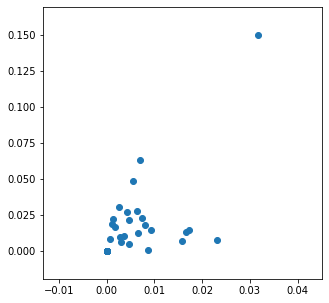

In [1758]:
plt.figure(figsize=(5,5))
plt.scatter(copula[...,0],copula[...,2])

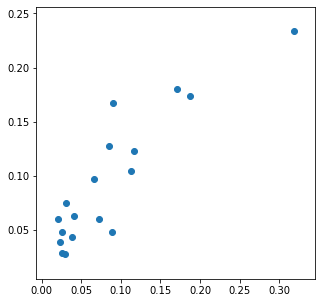

In [1759]:
plt.figure(figsize=(5,5))
plt.scatter(marginal[0,3:],marginal[2,3:])

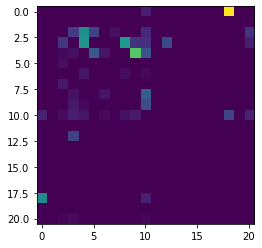

In [1760]:
plt.imshow(copula[...,0]+(copula[...,2]/10).T)

In [1761]:
list_files

['../models/MI_measures/ST260_Day1_copulaMI.pkl',
 '../models/MI_measures/ST264_Day4_copulaMI.pkl',
 '../models/MI_measures/ST262_Day2_copulaMI.pkl',
 '../models/MI_measures/ST260_Day3_copulaMI.pkl',
 '../models/MI_measures/ST262_Day4_copulaMI.pkl',
 '../models/MI_measures/ST264_Day3_copulaMI.pkl',
 '../models/MI_measures/ST260_Day4_copulaMI.pkl',
 '../models/MI_measures/ST263_Day1_copulaMI.pkl',
 '../models/MI_measures/ST263_Day4_copulaMI.pkl',
 '../models/MI_measures/ST264_Day1_copulaMI.pkl']

In [1762]:
#copula0[...,2] = -copula0[...,2] #messed up with entropy sign
#copula0[...,3] = -copula0[...,3] #messed up with entropy signHc = copula[...,2].flatten()
#Hc = copula0[7:,7:,0].flatten()
#print(np.sum(Hc==0))
#print(np.median(Hc[Hc>np.median(Hc[Hc>0])]),np.std(Hc[Hc>0]))
#plt.hist(Hc[Hc>0], density=True, alpha=0.3)
def points(filenames):
    l = []
    for filename in filenames:
        marginal0, copula0 = load_data(filename)
        H1 = copula0[7:,7:,0].flatten()
        H2 = copula0[7:,7:,2].flatten()
        l.append([H1[H1>1e-3].mean(),H2[H2>1e-3].mean()])
    return np.array(l).T

filenames = [f"../models/MI_measures/ST260_Day{d}_copulaMI.pkl" for d in [1,3,4]]
plt.plot(*points(filenames))
plt.scatter(*points(filenames)[:,-1])
filenames = [f"../models/MI_measures/ST262_Day{d}_copulaMI.pkl" for d in [2,4]]
plt.plot(*points(filenames))
plt.scatter(*points(filenames)[:,-1])
filenames = [f"../models/MI_measures/ST263_Day{d}_copulaMI.pkl" for d in [1,4]]
plt.plot(*points(filenames))
plt.scatter(*points(filenames)[:,-1])
filenames = [f"../models/MI_measures/ST264_Day{d}_copulaMI.pkl" for d in [1,3,4]]
plt.plot(*points(filenames))
plt.scatter(*points(filenames)[:,-1])
plt.xlabel('MI vs pos')
plt.ylabel('H')

ValueError: too many values to unpack (expected 2)

In [1763]:
import numpy as np
rel = copula[...,1]/copula[...,0]
np.max(rel[rel==rel])

/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.9036106544082378